In [2]:
import numpy as np
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class KinematicModel:

    def __init__(self, y, theta, Lmax, l, d, p1, sigmaC, p2):
        self.y = y
        self.theta = theta
        self.Lmax = Lmax
        self.l = l
        self.d = d
        self.p1 = p1 # probability of curve event
        self.sigmaC = sigmaC
        self.p2 = p2 # probability of next vehicle event

    def input(self, action):
        noise = norm.rvs(loc=0, scale=action[0] / 4)
        self.y = self.y + action[0] * math.sin(action[1] + noise + self.theta)
        nextVehicleEvent = random.random()
        if nextVehicleEvent < self.p2:
            self.d = self.d + (self.l - action[0] * math.cos(action[1] + noise + self.theta))
        else:
            self.d = 40
        curveEvent = random.random()
        if curveEvent < self.p1:
            curveAngle = norm.rvs(loc=0, scale=self.sigmaC)
            self.theta = self.theta + curveAngle

In [4]:
# Probability of going out of a STRAIGHT ROAD given an action 
def P1(action, environment, sigma, show = True):

    # Term 1 is the probability that y > Lmax
    term1 = math.degrees(math.asin((environment.Lmax - environment.y) / action[0]))
    term1 = 1 - norm.cdf((1 / sigma) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")

    # Term 2 is the probability that y < -Lmax
    term2 = math.degrees(math.asin((- environment.Lmax - environment.y) / action[0]))
    term2 = norm.cdf((1 / sigma) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    
    # Final probability is a weighted sum of the two terms, adjusted by the p1 probability
    value = (1 - environment.p1) * (term1 + term2)
    if show:
        print(f"Value: {value}")
    return value, term1, term2
    
# Probability of going out of a CURVED ROAD given an action
def P2(action, environment, sigma, show = True):

    # Term 1 is the probability that y > Lmax
    term1 = math.degrees(math.asin((environment.Lmax - environment.y) / action[0]))
    term1 = 1 - norm.cdf((1 / sigma) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")

    # Term 2 is the probability that y < -Lmax
    term2 = math.degrees(math.asin((- environment.Lmax - environment.y) / action[0]))
    term2 = norm.cdf((1 / sigma) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    
    value = environment.p1 * (term1 + term2)
    if show:
        print(f"Value: {value}")
    return value, term1, term2

# Probability of risking a CRASH in a STRAIGHT ROAD given an action 
def P3(action, environment, sigma, show = True):
    
    # checks if the calculated distance to the vehicle in front is too large for a crash
    if (1 / action[0]) * (environment.l + ( ((action[0] * 3.6) / -2) + environment.d)) > 1:
        return 0 # If the value exceeds 1, no risk of a crash
    
    # Calculate the angle of the potential collision based on the current action and environment
    value = math.degrees(math.acos((1 / action[0]) * (environment.l + (((action[0] * 3.6) / -2) + environment.d))))
    # Probability of the collision is calculated using the normal distribution's cumulative density function (CDF)
    value = norm.cdf((1 / sigma) * (value - math.fabs(action[1]) - math.fabs(environment.theta)))
    
    value = environment.p2 * (1 - environment.p1) * value
    if show:
        print(f"Value: {value}")
    return value

# Probability of risking a CRASH in a CURVED ROAD given an action
def P4(action, environment, sigma, show = True):
    # checks if the calculated distance to the vehicle in front is too large for a crash
    if (1 / action[0]) * (environment.l + ( ((action[0] * 3.6) / -2) + environment.d)) > 1:
        return 0 # If the value exceeds 1, no risk of a crash
    value = math.degrees(math.acos((1 / action[0]) * (environment.l + (((action[0] * 3.6) / -2) + environment.d))))
    value = norm.cdf((1 / sigma) * (value - math.fabs(action[1]) - math.fabs(environment.theta)))
    
    value = environment.p2 * environment.p1 * value
    if show:
        print(f"Value: {value}")
    return value

In [5]:
# 0 = S_G: good state
# 1 = S_X: out of road state
# 2 = S_I: risk of crash state
# 3 = S_XI: out of road and risk of crash state

# Environment starts:
# - At center of the road y = 0 m
# - Aligned with the road theta = 0°
# - Road width 4 m Lmax = 2 m
# - Road limit 90 km/h l = 25 m/s
# - Distance from next vehicle d = 40 m
# - Probability of a road curve p1 = 5%
# - Variance of the curve sigmaC = 5
# - Probability of a vehicle in front p2 = 30%
#kinematicModel = KinematicModel(-1.8798570530529481, -1.8851942218687283, 2, 25, 40.070777439717716, 0.05, 5, 0.3)
kinematicModel = KinematicModel(0, 0, 2, 25, 40.070777439717716, 0.5, 5, 0.3)

# Test
testAnglesDeg = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
testVelocities = [20, 25, 30]
testActions = [(v, delta) for v in testVelocities for delta in testAnglesDeg]
print(testActions)

[(20, -5), (20, -4), (20, -3), (20, -2), (20, -1), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (25, -5), (25, -4), (25, -3), (25, -2), (25, -1), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (30, -5), (30, -4), (30, -3), (30, -2), (30, -1), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5)]


Value: 0.29436853123695
Value: 0.27359061383836836
Value: 0.2560116106239195
Value: 0.24263852176450226
Value: 0.23427077043133793
Value: 0.23142240977201164
Value: 0.23427077043133793
Value: 0.24263852176450224
Value: 0.25601161062391947
Value: 0.27359061383836836
Value: 0.29436853123695006


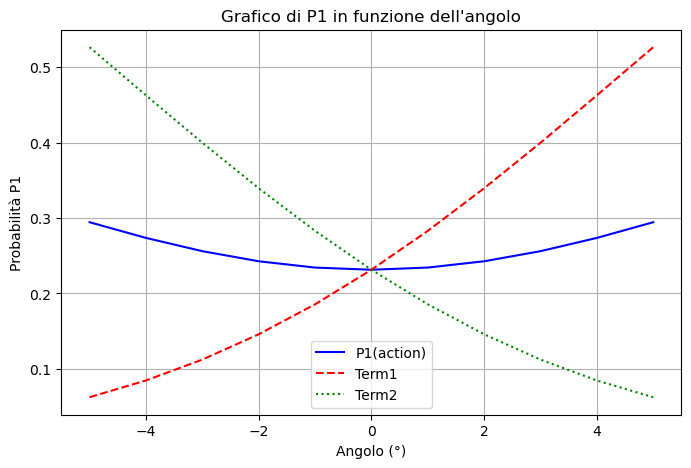

In [6]:
# P1 test
P1_values = []
term1_values = []
term2_values = []
for angle in testAnglesDeg:
    action = (25, angle)
    P1_val, term1_val, term2_val = P1(action, kinematicModel, action[0]/4)
    P1_values.append(P1_val)
    term1_values.append(term1_val)
    term2_values.append(term2_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P1_values, label="P1(action)", color="b", linestyle="-")
plt.plot(testAnglesDeg, term1_values, label="Term1", color="r", linestyle="--")
plt.plot(testAnglesDeg, term2_values, label="Term2", color="g", linestyle=":")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P1")
plt.title("Grafico di P1 in funzione dell'angolo")
plt.legend()
plt.grid()

Value: 0.2771599057114864
Value: 0.24021227659678876
Value: 0.2075283261056816
Value: 0.1818399182040213
Value: 0.16541962244023925
Value: 0.15977096054529782
Value: 0.16541962244023928
Value: 0.18183991820402126
Value: 0.20752832610568156
Value: 0.24021227659678876
Value: 0.2771599057114864


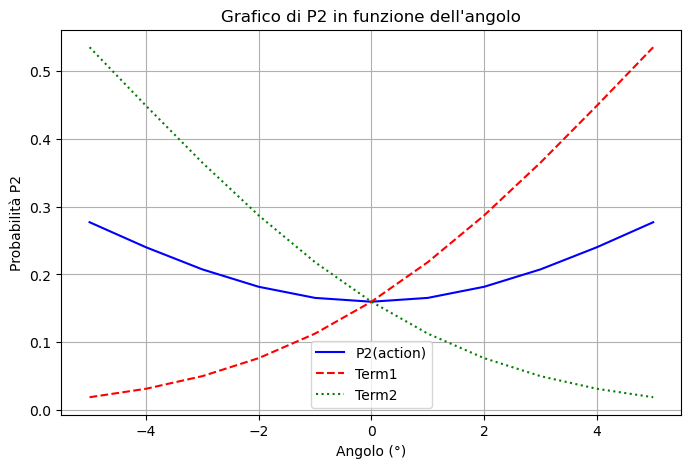

In [7]:
# P2 test
P2_values = []
term1_values = []
term2_values = []
for angle in testAnglesDeg:
    action = (25, angle)
    P2_val, term1_val, term2_val = P2(action, kinematicModel, math.sqrt(action[0]/4 + 15))
    P2_values.append(P2_val)
    term1_values.append(term1_val)
    term2_values.append(term2_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P2_values, label="P2(action)", color="b", linestyle="-")
plt.plot(testAnglesDeg, term1_values, label="Term1", color="r", linestyle="--")
plt.plot(testAnglesDeg, term2_values, label="Term2", color="g", linestyle=":")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P2")
plt.title("Grafico di P2 in funzione dell'angolo")
plt.legend()
plt.grid()

Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15
Value: 0.15


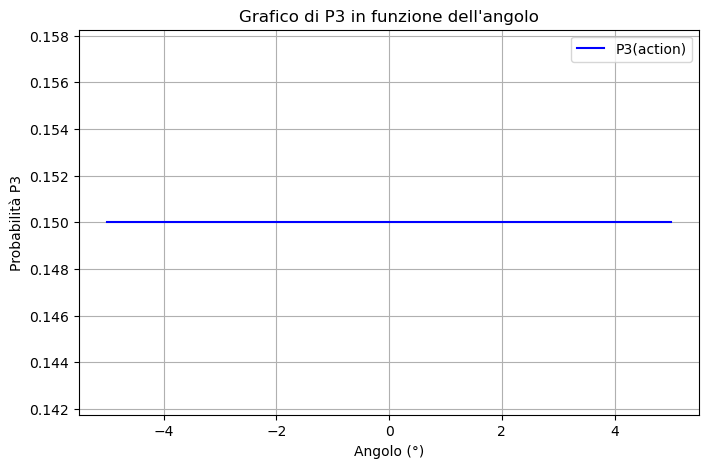

In [8]:
# P3 test
P3_values = []
for angle in testAnglesDeg:
    action = (30, angle)
    P3_val = P3(action, kinematicModel, action[0]/4)
    P3_values.append(P3_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P3_values, label="P3(action)", color="b", linestyle="-")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P3")
plt.title("Grafico di P3 in funzione dell'angolo")
plt.legend()
plt.grid()

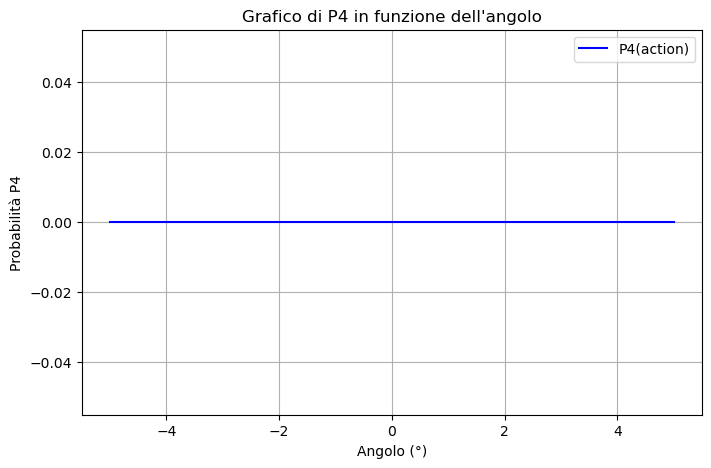

In [9]:
# P4 test
P4_values = []
for angle in testAnglesDeg:
    action = (20, angle)
    P4_val = P4(action, kinematicModel, math.sqrt(action[0]/4 + 15))
    P4_values.append(P4_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P4_values, label="P4(action)", color="b", linestyle="-")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P4")
plt.title("Grafico di P4 in funzione dell'angolo")
plt.legend()
plt.grid()

In [10]:
# Transition probabilities

# Transition probability from any state to a Good State (S_G)
def anyToG(action, environment):
    # Compute probability of going off the road (straight and curved parts)
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of NOT going out of the road
    # (1 - probability of going off-road, which is given by P1 + P2)
    term1 = 1 - (P1_val + P2_val)
    # Term 2 is the probability of NOT risking a crash
    # (1 - probability of crashing, where crash probability = P3 + P4)
    term2 = 1 - (P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False))
    return term1 * term2 # overall probability of being in a good state
    
# Transition probability from any state to an Out-of-Road State (S_X)
def anyToX(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of going out of the road
    term1 = P1_val + P2_val
    # Term 2 is the probability of NOT risking a crash
    term2 = 1 - (P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False))
    return term1 * term2 # overall probability of going off-road (and not crashing)

# Transition probability from any state to a Crash-Risk State (S_I)
def anyToI(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of NOT going out of the road
    term1 = 1 - (P1_val + P2_val)
    # Term 2 is the probability of risking a crash
    term2 = P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    return term1 * term2 # overall probability of being at risk of a crash (while staying on the road)

# Transition probability from any state to an Out-of-Road and Crash-Risk State (S_XI)
def anyToXI(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of going out of the road
    term1 = P1_val + P2_val
    # Term 2 is the probability of risking a crash
    term2 = P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    return term1 * term2 # overall probability of being out-of-road and at risk of a crash

def transitionProbabilitiesMatrix(actions, environment):
    # List of functions corresponding to transitions:
    # anyToG: Transition to Good State (S_G)
    # anyToX: Transition to Out-of-Road State (S_X)
    # anyToI: Transition to Crash-Risk State (S_I)
    # anyToXI: Transition to Out-of-Road and Crash-Risk State (S_XI)
    transitions = [anyToG, anyToX, anyToI, anyToXI]

    # Build the transition matrix:
    # For each action in the provided 'actions' list, compute the probability for each transition.
    transitionMatrix = np.array([[transition(action, kinematicModel) for transition in transitions] for action in actions])
    return transitionMatrix

In [11]:
# Reward for staying at the center of the road
def rewardCenterProbability(action, environment, ratio, show = True):
    # Term 1 is the probability that y < Lmax * ratio
    # the angular offset corresponding to the distance from the vehicle's current lateral position (environment.y)
    # to the right boundary of the safe region (Lmax * ratio). The safe region is a fraction of the maximum lateral limit.
    term1 = math.degrees(math.asin(((environment.Lmax * ratio) - environment.y) / action[0]))
    
    # Compute a variant of Term 1 (term1C) using a noise scaling factor that includes the environment's curve variance (environment.sigmaC)
    # Here, math.sqrt(action[0]/4 + environment.sigmaC) adjusts the noise based on the current speed and the curve variance.
    term1C = norm.cdf((1 / math.sqrt(action[0]/4 + environment.sigmaC)) * (term1 - action[1] - environment.theta))
    
    # Recompute Term 1 as the cumulative probability (using norm.cdf) after adjusting 
    # by the steering angle (action[1]) and the vehicle's current orientation (environment.theta).
    term1 = norm.cdf((1 / action[0]/4) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")
    
    # Term 2: the angular offset corresponding to the distance from the vehicle's current lateral position (environment.y)
    # to the left boundary of the safe region (-Lmax * ratio)
    # Term 2 is the probability that y > -Lmax * ratio
    term2 = math.degrees(math.asin(((-environment.Lmax * ratio) - environment.y) / action[0]))
    term2C = norm.cdf((1 / math.sqrt(action[0]/4 + environment.sigmaC)) * (term2 - action[1] - environment.theta))
    term2 = norm.cdf((1 / action[0]/4) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    
    # Combine the terms using the probability of encountering a curve (environment.p1)
    # - When the road is straight (weight 1 - p1), the reward is proportional to (term1 - term2).
    # - When the road is curved (weight p1), the reward is proportional to (term1C - term2C).
    value = ((1 - environment.p1) * (term1 - term2)) + (environment.p1 * (term1C - term2C))
    if show:
        print(f"Value: {value}")
    return value

# Reward for going at the correct speed
def rewardSpeed(action, environment):
    # Penalize the difference between the desired speed (environment.l, assumed to be the speed limit)
    # and the current speed (action[0]). A perfect match gives 0 penalty, and any deviation results in a negative reward.
    return -(math.fabs(environment.l - action[0]))

# Reward for staying at the correct distance (minimizing risk of a crash)
def rewardDistanceProbability(action, environment):
    # Probability of risking a crash in a straight road given an action 
    term1 = P3(action, environment, action[0] / 4, False)
    #Probability of risking a crash in a curved road given an action
    term2 = P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    return term1 + term2

# Expected reward given an action by combining multiple aspects of performance
def expectedReward(action, environment, r1, r2, r3, r4, show = True):
    # Reward component for staying near the center of the road with a safe margin.
    # Here, ratio 0.5 might represent a wider safe zone.
    termR1 = r1 * rewardCenterProbability(action, environment, 0.5, False)
    #print(f"Term r1: {termR1}")
    
    # Another reward component for center alignment, using a tighter safe zone (ratio 0.25).
    termR2 = r2 * rewardCenterProbability(action, environment, 0.25, False)
    #print(f"Term r2: {termR2}")
    
    # Speed reward: penalizes deviation from the desired speed.
    rSpeed = rewardSpeed(action, environment)
    
    # Reward component for avoiding a crash: we want a low crash risk.
    # (1 - rewardDistanceProbability) gives a higher value when the crash risk is low.
    termR3 = r3 * (1 - rewardDistanceProbability(action, environment))
    #print(f"Term r3: {termR3}")
    
    # Additional penalty or reward based directly on the crash risk.
    termR4 = r4 * rewardDistanceProbability(action, environment)
    #print(f"Term r4: {termR4}")
    
    # Calculate the overall expected reward by summing all components.
    total_reward = termR1 + termR2 + rSpeed + termR3 + termR4

    if show:
        print(f"Reward for action [{action[0]}, {action[1]}]: {round(total_reward, 2)}")
    
    return total_reward



Reward for action [20, -5]: 6.95
Reward for action [20, -4]: 12.33
Reward for action [20, -3]: 18.19
Reward for action [20, -2]: 23.57
Reward for action [20, -1]: 27.4
Reward for action [20, 0]: 28.78
Reward for action [20, 1]: 27.4
Reward for action [20, 2]: 23.57
Reward for action [20, 3]: 18.19
Reward for action [20, 4]: 12.33
Reward for action [20, 5]: 6.95
Reward for action [25, -5]: 9.68
Reward for action [25, -4]: 13.84
Reward for action [25, -3]: 18.29
Reward for action [25, -2]: 22.34
Reward for action [25, -1]: 25.2
Reward for action [25, 0]: 26.23
Reward for action [25, 1]: 25.2
Reward for action [25, 2]: 22.34
Reward for action [25, 3]: 18.29
Reward for action [25, 4]: 13.84
Reward for action [25, 5]: 9.68
Reward for action [30, -5]: 3.09
Reward for action [30, -4]: 6.38
Reward for action [30, -3]: 9.84
Reward for action [30, -2]: 12.93
Reward for action [30, -1]: 15.08
Reward for action [30, 0]: 15.86
Reward for action [30, 1]: 15.08
Reward for action [30, 2]: 12.93
Reward

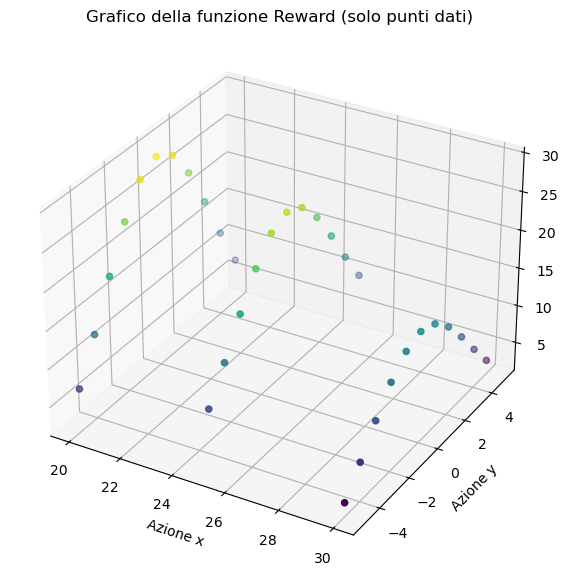

In [12]:
# Estrai i valori delle azioni
x_vals = [action[0] for action in testActions] # speed 
y_vals = [action[1] for action in testActions] # steering angle

# Compute the expected reward for each action:
# - action: the current action tuple (speed, steering angle)
# - kinematicModel: the environment model containing the vehicle and road parameters
# - 50, 100, -1, 0: coefficients (r1, r2, r3, r4) for weighting the different reward components.
reward_values = [expectedReward(action, kinematicModel, 50, 100, -1, 0) for action in testActions]

# Creazione del grafico 3D con i punti reali
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# - x_vals: x-axis data (action's speed)
# - y_vals: y-axis data (action's steering angle)
# - reward_values: z-axis data (computed reward for each action)
ax.scatter(x_vals, y_vals, reward_values, c=reward_values, cmap="viridis", marker='o')

# Etichette
ax.set_xlabel("Azione x")
ax.set_ylabel("Azione y")
ax.set_zlabel("Reward")
ax.set_title("Grafico della funzione Reward (solo punti dati)")

plt.show()

Reward for action [20.0, -5.0]: 6.95
Reward for action [21.11, -5.0]: 7.35
Reward for action [22.22, -5.0]: 7.85
Reward for action [23.33, -5.0]: 8.65
Reward for action [24.44, -5.0]: 9.34
Reward for action [25.56, -5.0]: 8.91
Reward for action [26.67, -5.0]: 7.41
Reward for action [27.78, -5.0]: 5.94
Reward for action [28.89, -5.0]: 4.5
Reward for action [30.0, -5.0]: 3.09
Reward for action [20.0, -3.89]: 12.97
Reward for action [21.11, -3.89]: 13.03
Reward for action [22.22, -3.89]: 13.2
Reward for action [23.33, -3.89]: 13.73
Reward for action [24.44, -3.89]: 14.12
Reward for action [25.56, -3.89]: 13.44
Reward for action [26.67, -3.89]: 11.7
Reward for action [27.78, -3.89]: 10.01
Reward for action [28.89, -3.89]: 8.37
Reward for action [30.0, -3.89]: 6.77
Reward for action [20.0, -2.78]: 19.46
Reward for action [21.11, -2.78]: 19.13
Reward for action [22.22, -2.78]: 18.93
Reward for action [23.33, -2.78]: 19.14
Reward for action [24.44, -2.78]: 19.2
Reward for action [25.56, -2.78

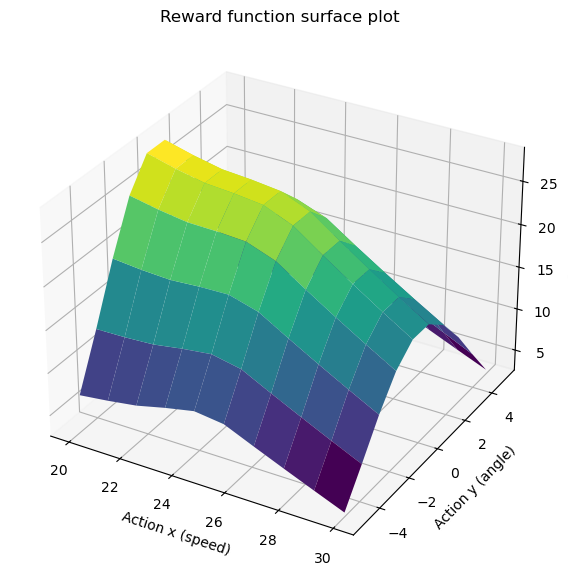

In [13]:
# Extract the values of the actions from testActions
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedReward(action, kinematicModel, 50, 100, -1, 0, False) for action in testActions]

# Create a grid of X and Y values for the plot.
# np.linspace generates 10 evenly spaced values between the minimum and maximum of x_vals and y_vals.
X, Y = np.meshgrid(np.linspace(min(x_vals), max(x_vals), 10),
                   np.linspace(min(y_vals), max(y_vals), 10))

# Calculate the reward value (Z) for each point on the grid.
# For each grid coordinate (X[i, j], Y[i, j]), we compute the expected reward using the same coefficients.
Z = np.array([[expectedReward([X[i, j], Y[i, j]], kinematicModel, 50, 100, -1, 0, False) 
               for j in range(X.shape[1])] for i in range(X.shape[0])])
for i in range(X.shape[0]): #  print out the reward for each grid point.
    for j in range(X.shape[1]):
        print(f"Reward for action [{round(X[i, j], 2)}, {round(Y[i, j], 2)}]: {round(Z[i, j], 2)}")

# Create a 3D figure to visualize the reward function as a surface.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis") 

# Labels    
ax.set_xlabel("Action x (speed)")
ax.set_ylabel("Action y (angle)")
ax.set_zlabel("Reward")
ax.set_title("Reward function surface plot")

plt.show()

In [14]:
import plotly.graph_objects as go
import numpy as np

# Assumiamo che x_vals, y_vals e reward_values siano già definiti, ad esempio:
# x_vals = [action[0] for action in testActions]
# y_vals = [action[1] for action in testActions]
# reward_values = [expectedReward(action, kinematicModel, 50, 100, -1, 0, False) for action in testActions]

# Create an interactive 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=x_vals,                 # x-axis data (e.g., speed component)
    y=y_vals,                 # y-axis data (e.g., steering angle)
    z=reward_values,          # z-axis data (reward values)
    mode='markers',           # display as markers (points)
    marker=dict(
        size=5,               # marker size
        color=reward_values,  # marker colors based on reward values
        colorscale='Viridis', # colormap
        opacity=0.8,          # transparency level
        colorbar=dict(title="Reward")  # colorbar legend
    ),
    # Display additional text information on hover
    text=[f"Reward: {round(r,2)}" for r in reward_values],
    hoverinfo="text"
)])

# Update layout to add axis titles and a plot title
fig.update_layout(
    scene=dict(
        xaxis_title="Azione x",   # x-axis title
        yaxis_title="Azione y",   # y-axis title
        zaxis_title="Reward"      # z-axis title
    ),
    title="Interactive 3D Plot of Reward Function"
)

# Display the interactive plot
fig.show()


In [15]:
import plotly.graph_objects as go
import numpy as np

# Assumiamo che x_vals, y_vals e reward_values siano già definiti
# x_vals = [action[0] for action in testActions]  # velocità
# y_vals = [action[1] for action in testActions]  # angolo di sterzo
# reward_values = [expectedReward(action, kinematicModel, 50, 100, -1, 0, False) for action in testActions]

# Creiamo una griglia per la superficie
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
z_vals = np.array(reward_values)

# Creiamo una meshgrid per la superficie
x_grid, y_grid = np.meshgrid(np.unique(x_vals), np.unique(y_vals))
z_grid = z_vals.reshape(len(np.unique(y_vals)), len(np.unique(x_vals)))

# Creiamo la superficie
fig = go.Figure(data=[go.Surface(
    x=x_grid,  # x-axis data (velocità)
    y=y_grid,  # y-axis data (angolo di sterzo)
    z=z_grid,  # z-axis data (reward values)
    colorscale='Viridis',  # colormap
    colorbar=dict(title="Reward")  # colorbar legend
)])

# Aggiorniamo il layout per aggiungere titoli e un titolo al grafico
fig.update_layout(
    scene=dict(
        xaxis_title="Velocità",  # x-axis title
        yaxis_title="Angolo di Sterzo",  # y-axis title
        zaxis_title="Reward"  # z-axis title
    ),
    title="Superficie della Funzione di Reward"
)

# Mostra il grafico interattivo
fig.show()